In [15]:
%load_ext autoreload
%autoreload 2

In [26]:
# Train the ML model
from local_models import Tomoscope
from local_utils import plot_loss
from local_utils import fast_tensor_load_encdec

import time
import tensorflow as tf
from tensorflow import keras
import yaml
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt


In [27]:
num_Turns_Case = 1
var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
# Initialize parameters
data_dir = './tomo_data/datasets_tomoscope_TF_24-03-23/'

timestamp = datetime.now().strftime("%Y_%m_%d_%H-%M-%S")
timestamp = 'tomoscope_test'
print('Using timestamp: ', timestamp)



Using timestamp:  tomoscope_test


In [28]:
# Data specific
IMG_OUTPUT_SIZE = 128

# Train specific
train_cfg = {
    'epochs': 10, 'output_turns': 10,
    'cropping': [0, 0],
    'enc_dense_layers': [1024, 256],
    'dec_dense_layers': [1024],
    'enc_filters': [4, 8, 16],
    'dec_filters': [8, 16, 2],
    'enc_kernel_size': 3,
    'dec_kernel_size': 3,
    'enc_strides': [2, 2],
    'dec_strides': [2, 2],
    'enc_activation': 'relu',
    'dec_activation': 'relu',
    'enc_pooling': None, 'dec_pooling': None,
    'enc_pooling_size': [0, 0], 'dec_pooling_size': [0, 0],
    'enc_pooling_strides': [1, 1], 'dec_pooling_strides': [1, 1],
    'enc_pooling_padding': 'valid', 'dec_pooling_padding': 'valid',
    'enc_dropout': 0.0, 'dec_dropout': 0.0,
    'loss': 'mse', 'metrics': [], 'use_bias': False, 'batchnorm': False,
    'learning_rate': 1e-3,
    'dataset%': 0.1,
    'normalization': 'minmax', 'img_normalize': 'off',
    'batch_size': 32
}


In [29]:
# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
assert os.path.exists(ML_dir)

TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
VALIDATION_PATH = os.path.join(ML_dir, 'VALIDATION')

# create the directory to store the results
os.makedirs(trial_dir, exist_ok=True)
os.makedirs(weights_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)


assert train_cfg['normalization'] == 'minmax'
assert train_cfg['img_normalize'] == 'off'

TRAINING_PATH = os.path.join(ML_dir, 'tomoscope-training-??.npz')
VALIDATION_PATH = os.path.join(ML_dir, 'tomoscope-validation-??.npz')

x_train, turn_train, latent_train, y_train = fast_tensor_load_encdec(
    TRAINING_PATH, train_cfg['dataset%'])
print('Number of Training files: ', len(y_train))

x_valid, turn_valid, latent_valid, y_valid = fast_tensor_load_encdec(
    VALIDATION_PATH, train_cfg['dataset%'])
print('Number of Validation files: ', len(y_valid))

1
Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-training-00.npz
ps shape: (15898, 128, 128, 1)
Number of Training files:  1589
1
Loading ./tomo_data/datasets_tomoscope_TF_24-03-23/ML_data/tomoscope-validation-00.npz
ps shape: (1404, 128, 128, 1)
Number of Validation files:  140


In [25]:
print('Training data shape: ', x_train.shape, y_train.shape)
print('turns data shape: ', turn_train.shape)
print('latent data shape: ', latent_train.shape)
print('y data shape: ', y_train.shape)

Training data shape:  (1589, 128, 128, 1) (1589, 128, 128, 1)
turns data shape:  (1589, 1)
latent data shape:  (1589, 7)
y data shape:  (1589, 128, 128, 1)


In [11]:
# print(x_train.shape, y_train.shape)
new_y_train = tf.stack([x_train] * train_cfg['output_turns'], axis=-1)
new_y_train = tf.reshape(new_y_train, (new_y_train.shape[0], new_y_train.shape[1], new_y_train.shape[2], -1))
print(new_y_train.shape)

new_y_valid = tf.stack([x_valid] * train_cfg['output_turns'], axis=-1)
new_y_valid = tf.reshape(new_y_valid, (new_y_valid.shape[0], new_y_valid.shape[1], new_y_valid.shape[2], -1))
print(new_y_valid.shape)

(1589, 128, 128, 2)
(140, 128, 128, 2)


In [32]:
# x_train_reduced = x_train[:, 14:-14]
# print(x_train_reduced.shape)

# x_valid_reduced = x_valid[:, 14:-14]
# print(x_valid_reduced.shape)

# new_y_train_reduced = new_y_train[:, 14:-14]
# print(new_y_train_reduced.shape)

# new_y_valid_reduced = new_y_valid[:, 14:-14]
# print(new_y_valid_reduced.shape)




(1589, 100, 128, 1)
(140, 100, 128, 1)
(1589, 100, 128, 2)
(140, 100, 128, 2)


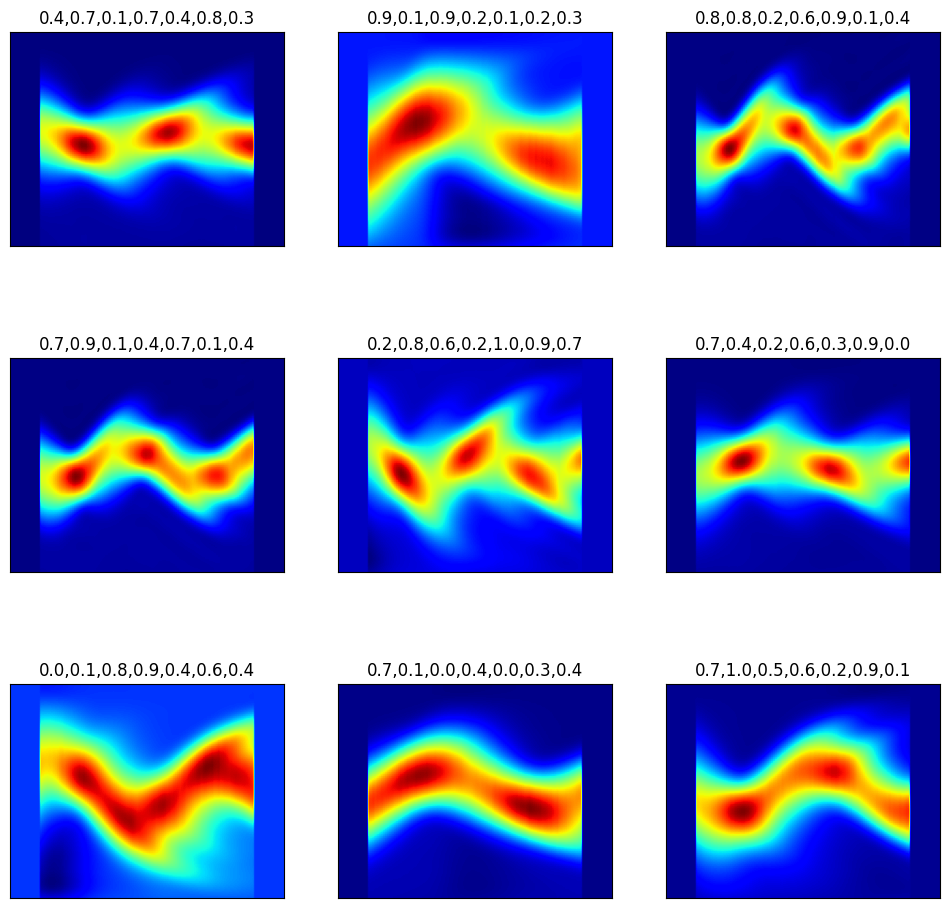

In [33]:
%matplotlib inline
# plot some of the outputs

nrows = 3
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(x_train)),
                          size=nrows * nrows, replace=False)

samples_X = tf.gather(x_train, sample)
samples_y = tf.gather(y_train, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(axes)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    title = ','.join([f'{num:.1f}' for num in samples_y[i]])
    ax.set_title(f'{title}')


In [42]:
from local_models import Tomoscope
# Model instantiation
start_t = time.time()
input_shape = x_train.shape[1:]
models = {}

print(f'\n---- Initializing model ----\n')


import keras.backend as K

def custom_loss(ps_true, ps_pred):
    """Custom loss function that recreates the WF from the PS and compares them.

    Args:
        ps_true (_type_): The true PS with dim (128, 128, output_turns)
        ps_pred (_type_): The predicted PS with dim (128, 128, output_turns)

    Returns:
        _type_: _description_
    """
    # print(ps_pred.shape, ps_true.shape)

    wf_pred = K.sum(ps_pred, axis=1)
    wf_true = K.sum(ps_true, axis=1)
    # print(wf_pred.shape, wf_true.shape)
    loss = K.mean(K.square(wf_true - wf_pred))
    return loss

train_cfg['loss'] = custom_loss

tomoscope = Tomoscope(input_shape=input_shape, **train_cfg)
print(tomoscope.model.summary())

print(
    f'\n---- Models have been initialized, elapsed: {time.time() - start_t} ----\n')



---- Initializing model ----

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 128, 1)]     0         
                                                                 
 crop (Cropping2D)           (None, 128, 128, 1)       0         
                                                                 
 encoder_cnn_1 (Conv2D)      (None, 63, 63, 4)         36        
                                                                 
 tf.nn.relu_21 (TFOpLambda)  (None, 63, 63, 4)         0         
                                                                 
 encoder_cnn_2 (Conv2D)      (None, 31, 31, 8)         288       
                                                                 
 tf.nn.relu_22 (TFOpLambda)  (None, 31, 31, 8)         0         
                                                                 
 encoder_cnn_3 (Conv2D)     

In [ ]:

print(f'\n---- Training the model ----\n')

# callbacks, save the best model, and early stop if no improvement in val_loss
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=10, restore_best_weights=True)
save_best = keras.callbacks.ModelCheckpoint(filepath=os.path.join(weights_dir, f'tomoscope.h5'),
                                            monitor='val_loss', save_best_only=True)

start_time = time.time()

history = tomoscope.model.fit(
    x=x_train, y=new_y_train, 
    epochs=train_cfg['epochs'],
    validation_data=(x_valid, new_y_valid),
    callbacks=[save_best], 
    batch_size=train_cfg['batch_size'],
    verbose=0)

total_time = time.time() - start_time
print(
    f'\n---- Training complete, epochs: {len(history.history["loss"])}, min loss {np.min(history.history["val_loss"])}, total time {total_time} ----\n')


In [44]:
print(custom_loss(new_y_train[0:1], tomoscope.model(x_train[0:1])))
print(np.mean(tf.keras.metrics.mean_squared_error(new_y_train[0:1], tomoscope.model(x_train[0:1]))))

tf.Tensor(0.8296597, shape=(), dtype=float32)
0.008987858


In [45]:
%matplotlib inline

# Plot training and validation loss
print('\n---- Plotting loss ----\n')

train_loss_l = np.array(history.history['loss'])
valid_loss_l = np.array(history.history['val_loss'])

plot_loss({'Training': train_loss_l, 'Validation': valid_loss_l},
            title='Encoder Train/Validation Loss',
            figname=os.path.join(plots_dir, 'encoder_train_valid_loss.png'))


---- Plotting loss ----



In [ ]:
# save file with experiment configuration
config_dict = {}
config_dict['encoder'] = train_cfg.copy()
config_dict['encoder'].update({
    'min_train_loss': float(np.min(train_loss_l)),
    'min_valid_loss': float(np.min(valid_loss_l)),
    'total_train_time': total_time,
    'used_gpus': 0
})

# save config_dict
with open(os.path.join(trial_dir, 'tomoscope-summary.yml'), 'w') as configfile:
    yaml.dump(config_dict, configfile, default_flow_style=False)
